In [1]:
import tensorflow as tf, numpy as np, pandas

In [2]:
# Fonction d'initialisation des variables de poids
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

In [3]:
# Notre modèle sera, d'après l'article, sur une architecture 40 - 41 - 41 - 4
# <inputs> - 40
# <hidden> - 41
# <hidden> - 41
# <output> -  4
def model(X, w_h1, w_h2, w_o):
    # =====================================================================================================
    # X    : les inputs, shape [n x 40]
    # w_h1 : les poids du premier hidden layer, shape [40 x 41]
    # w_h2 : les poids du second hidden layer, shape [41 x 41]
    # w_o  : les poids du layer d'output, shape [41 x 4]
    # vérification : [n x 40] [40 x 41] [41 x 41] [41 x 4] = [n x 4]
    # =====================================================================================================

    h1 = tf.nn.tanh(tf.matmul(X, w_h1))

    h2 = tf.nn.tanh(tf.matmul(h1, w_h2))

    return tf.nn.tanh(tf.matmul(h2, w_o))

In [ ]:
# Bon, ici, on charge les données qui vont nous servir pour les tests.
# Quatre indices : Dow, Nasdaq, Rates, SNP500
Dow = pandas.read_csv("dow.csv", sep=",")
print(Dow[:5]) # Donc le Dow ressemble à ça

In [ ]:
Nasdaq = pandas.read_csv("nasdaq.csv", sep=",")
print(Nasdaq[:5])

In [ ]:
SnP500 = pandas.read_csv("SP500.csv", sep=",")
print(SnP500[:5])

In [ ]:
Rates = pandas.read_csv("rates.csv", sep=",")
print(Rates[:5])

In [ ]:
# On observe déjà quelques soucis au niveau de l'index Rates. Ensuite, les autres indexs sont de même formats
# mais pas de même taille / avec les mêmes dates
indexes = ("Dow", "Nasdaq", "SnP500", "Rates")
for var in indexes:
    print("{} : {}".format(var.rjust(6), eval(var).size))

In [ ]:
# Pour gérer ça, on va créer une nouvelle table.
# L'algorithme est simple : nous allons faire une intersection des données, pour ne pas avoir de jour présent
# dans une base, mais pas dans l'autre.
# A partir de là, il suffit de parcourir la base la moins fournie et de vérifier à chaque étape si la date
# est présente dans les autres. Si oui, on rajoute l'entrée complètement renseignée

# C'est le Nasdaq qui a le moins d'entrées.
# Autre info : on garde seulement la valeur de close des indices complets
datas = pandas.DataFrame(columns=['Date','Nasdaq', 'Dow', 'S&P500', 'Rates'])

# Constructing the dates in reverse order (du coup, chronologique)
for date in Nasdaq['Date'][::-1]:
    if date in Dow['Date'].values and date in SnP500['Date'].values and date[:-3] in Rates['date'].values:
        datas.loc[len(datas)] = [
            date, 
            float(Dow.loc[Dow['Date'] == date, 'Close']),
            float(Nasdaq.loc[Nasdaq['Date'] == date, 'Close']),
            float(SnP500.loc[SnP500['Date'] == date, 'Close']),
            float(Rates.loc[Rates['date'] == date[:-3], 'prime'])
        ]

In [ ]:
print(datas.head())

In [ ]:
# Maintenant que c'est fait, on sauvegarde en csv
datas.to_csv('datas.csv', sep=',', index=False)

In [ ]:
# Ici commence le traitement des données
# Selon l'article que nous essayons de reproduire, nous allons appliquer une normalisation des données dans [0, 1]

# La formule est la suivante : Index(x) = (Index(x) - Min(Index))/(Max(Index) - Min(Index))
processed = pandas.read_csv("datas.csv", sep=",")
print(processed.head())

for index in 'Nasdaq Dow S&P500 Rates'.split():
    M = max(processed.loc[:, index])
    m = min(processed.loc[:, index])
    for i in range(len(processed)):
        processed.loc[i, index] = (processed.loc[i, index] - m) / (M - m)
print(processed.head())

In [ ]:
# On sauvegarde les données <processed>
processed.to_csv('processed.csv', sep=',', index=False)

In [4]:
# Ici on les re-charge, au cas où
processed = pandas.read_csv("processed.csv", sep=",")

In [5]:
# Il reste encore quelques efforts sur les données
# On va créer un objet sample, qui contient 11 jours.

# La première nous fournira les 40 données d'input, dans une liste, sous cette forme :
# [Dow[i:i+10] Nasdaq[i:i+10] S&P[i:i+10] Rates[i:i+10]]
class Sample(object):
    def __init__(self, i):
        self.xdates = np.array(processed.loc[i:i+9, 'Date'])
        self.x = np.concatenate((
            np.array(processed.loc[i:i+9, 'Nasdaq']),
            np.array(processed.loc[i:i+9, 'Dow']),
            np.array(processed.loc[i:i+9, 'S&P500']),
            np.array(processed.loc[i:i+9, 'Rates'])
        ))
        self.ydate = np.array(processed.loc[i+10, 'Date'])
        self.y = np.array([
            processed.loc[i+10, 'Nasdaq'],
            processed.loc[i+10, 'Dow'],
            processed.loc[i+10, 'S&P500'],
            processed.loc[i+10, 'Rates']
        ])
    
sample = Sample(4)
print(sample.x)
print(sample.y)

[ 0.02264971  0.02290657  0.0229971   0.02283592  0.0226291   0.0221507
  0.02144561  0.02152068  0.02193431  0.02240241  0.00932766  0.00944781
  0.00947584  0.00938573  0.00932165  0.00917747  0.00897322  0.00898123
  0.00916546  0.0092836   0.02370797  0.02405398  0.02420702  0.02390094
  0.02347508  0.02292946  0.02225076  0.02249696  0.02292281  0.02307585
  0.15246377  0.15246377  0.15246377  0.15246377  0.15246377  0.15246377
  0.15246377  0.15246377  0.15246377  0.15246377]
[ 0.02217057  0.00930563  0.02293612  0.15246377]


In [6]:
p_train = 0.7
p_test = 1 - p_train
n = len(processed.Date.values)//11
samples = [
    Sample(i*11) for i in range(n)
]
from random import sample
indices = sample(samples, int(p_train*n))
train = np.array(indices)
test = []
for i in range(n):
    if samples[i] not in train:
        test.append(samples[i])

test = np.array(test)

print(len(train), len(test))

trX = np.array([tr.x for tr in train])
trY = np.array([tr.y for tr in train])
teX = np.array([te.x for te in test])
teY = np.array([te.y for te in test])

642 276


In [7]:
# Rappel :
# =====================================================================================================
# X    : les inputs, shape [n x 40]
# w_h1 : les poids du premier hidden layer, shape [40 x 41]
# w_h2 : les poids du second hidden layer, shape [41 x 41]
# w_o  : les poids du layer d'output, shape [41 x 4]
# vérification : [n x 40] [40 x 41] [41 x 41] [41 x 4] = [n x 4]
# =====================================================================================================

X = tf.placeholder("float", [None, 40])
Y = tf.placeholder("float", [None, 4])

w_h = init_weights([40, 41])
w_h2 = init_weights([41, 41])
w_o = init_weights([41, 4])

p_keep_input = tf.placeholder("float")   # La probabilité qui peut changer
p_keep_hidden = tf.placeholder("float")  # La probabilité qui peut changer
py_x = model(X, w_h, w_h2, w_o, p_keep_input, p_keep_hidden) # On construit le modèle avec X l'input externe

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=py_x, labels=Y))
train_op = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cost) # Ligne importante, tout se joue ici
# On train avec un optimizer ...

In [8]:
sess = tf.Session()

# Init variables
tf.global_variables_initializer().run(session=sess)

In [9]:
for i in range(20):
    for start, end in zip(range(0, len(trX), 10), range(10, len(trX)+1, 10)):
        # batches of 10
        sess.run(train_op, feed_dict={X: trX[start:end], Y: trY[start:end],
                                          p_keep_input: 1.0, p_keep_hidden: 1.0})
    if i % 200 == 0:
        pass
#         print(i, teY, sess.run(py_x, feed_dict={X: teX, Y: teY, p_keep_input: 1.0, p_keep_hidden: 1.0}))
print('finished')

In [10]:
print(teY[0:5], '\n', sess.run(py_x, feed_dict={X: teX[0:5], Y: teY[0:5], p_keep_input: 1.0, p_keep_hidden: 1.0}))

[[ 0.02368232  0.00997847  0.0248458   0.12695652]
 [ 0.02494088  0.01107985  0.02581062  0.13043478]
 [ 0.02088919  0.01020075  0.02245038  0.1542029 ]
 [ 0.02408638  0.01099775  0.0249456   0.15942029]
 [ 0.02278587  0.01084556  0.02399409  0.15942029]] 
 [[ 67.96429443  67.64094543  67.82937622  68.44441986]
 [ 69.82807922  69.49697876  69.68973541  70.31931305]
 [ 30.7574501   30.39392281  30.64519501  31.37360382]
 [ 34.3575592   33.98031998  34.2389679   34.9928894 ]
 [ 26.94470406  26.57163239  26.83348656  27.5847702 ]]


In [40]:
predicted = [None for i in range(10)]
Ys = []
Ps = []
for i in range(len(processed.Date)-11):
    Xv = np.concatenate((
            np.array(processed.loc[i:i+9, 'Nasdaq']),
            np.array(processed.loc[i:i+9, 'Dow']),
            np.array(processed.loc[i:i+9, 'S&P500']),
            np.array(processed.loc[i:i+9, 'Rates'])
        ))
    Xv = Xv.reshape((1,40))
    Yv = np.array([
            processed.loc[i+10, 'Nasdaq'],
            processed.loc[i+10, 'Dow'],
            processed.loc[i+10, 'S&P500'],
            processed.loc[i+10, 'Rates']
        ])
    Yv = Yv.reshape((1,4))
    predict = sess.run(py_x, feed_dict={X: Xv, Y: Yv, p_keep_input: 1.0, p_keep_hidden: 1.0})
    Ys += list(Yv)
    Ps += list(predict)
Ys = np.array(Ys)
Ps = np.array(Ps)
print('finished')

finished


In [47]:
from matplotlib import pyplot as plt
from matplotlib import dates as dt
from datetime import datetime

dates = np.array([datetime.strptime(x, '%Y-%m-%d') for x in processed.loc[11:,'Date']])
dates = dt.date2num(dates)

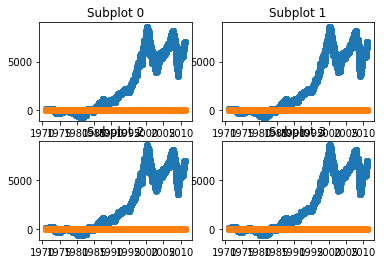

In [54]:
subs = [None for i in range(4)]
for i in range(4):
    subs[i] = plt.subplot(221 + i)

    subs[i].plot_date(dates, Ps[:,1], lw=0.1)
    subs[i].plot_date(dates, Ys[:,1], lw=0.1)
    subs[i].set_title("Subplot {}".format(i))
plt.show()